In [2]:
!module list

Currently Loaded Modulefiles:
 1) singularity   2) openmpi/4.1.5   3) NCI-ai-ml/24.08   4) pbs  
>

In [3]:
from math import ceil
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import torch

import sys,os,time
wdir="/g/data/z00/yxs900/neuraloperators/sfno/curriculum_learning/lowRes/experiments/03_LUCIE/"
sys.path.append(wdir)
from torch_harmonics_local import *
from LUCIE_inference import inference

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(0)

In [4]:
# load the ground truth for clim_bias from the original work
data = load_data(f"{wdir}/LUCIE_fix/era5_T30_regridded.npz")[...,:6]
true_clim = torch.tensor(np.mean(data, axis=0)).to(device).permute(2,0,1)

In [5]:
# load the normalization scalars from the original work
data = np.load(f"{wdir}/LUCIE_fix/era5_T30_preprocessed.npz")     # standardized data with mean and stds generated from dataset_generator.py
data_inp = torch.tensor(data["data_inp"],dtype=torch.float32)     # input data 
data_tar = torch.tensor(data["data_tar"],dtype=torch.float32)
raw_means = torch.tensor(data["raw_means"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
raw_stds = torch.tensor(data["raw_stds"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
prog_means = raw_means[:,:5]
prog_stds = raw_stds[:,:5]
diag_means = torch.tensor(data["diag_means"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
diag_stds = torch.tensor(data["diag_stds"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
diff_means = torch.tensor(data["diff_means"],dtype=torch.float32).reshape(1,-1,1,1).to(device)
diff_stds = torch.tensor(data["diff_stds"],dtype=torch.float32).reshape(1,-1,1,1).to(device)

In [6]:
# initialize the SFNO model
grid='legendre-gauss'
nlat = 48
nlon = 96
hard_thresholding_fraction = 0.9
lmax = ceil(nlat / 1)
mmax = lmax
modes_lat = int(nlat * hard_thresholding_fraction)
modes_lon = int(nlon//2 * hard_thresholding_fraction)
modes_lat = modes_lon = min(modes_lat, modes_lon)
sht = RealSHT(nlat, nlon, lmax=modes_lat, mmax=modes_lon, grid=grid, csphase=False)
radius=6.37122E6
cost, quad_weights = legendre_gauss_weights(nlat, -1, 1)
quad_weights = (torch.as_tensor(quad_weights).reshape(-1, 1)).to(device)
model = SphericalFourierNeuralOperatorNet(params = {}, spectral_transform='sht', filter_type = "linear", operator_type='dhconv', img_shape=(48, 96),
                    num_layers=8, in_chans=7, out_chans=6, scale_factor=1, embed_dim=72, activation_function="silu", big_skip=True, pos_embed="latlon", use_mlp=True,
                                            normalization_layer="instance_norm", hard_thresholding_fraction=hard_thresholding_fraction,
                                            mlp_ratio = 2.).to(device)

#load checkpoint trained on Gadi
path = torch.load(f'{wdir}/checkpoints/138987659.gadi-pbs/lucie_340.pt')
model.load_state_dict(path["model_state_dict"])

# run rollout for 10 years
forcing = data_inp[:1460,-2:]   # repeating tisr and constant oro
rollout_step = 14600
initial_frame_idx = 16000+100
forcing_initial_idx = (16000+100) % 1460 + 1
rollout = inference(model, rollout_step, data_inp[initial_frame_idx].unsqueeze(0).to(device), forcing.to(device), forcing_initial_idx, prog_means, prog_stds, diag_means, diag_stds, diff_stds)
print(rollout.shape)

(14600, 6, 48, 96)


# Visualize Rollout Results

In [7]:
# prepare for visualization
def generate_t30_grid():
    # T62 Gaussian grid parameters
    nlat = 48  # Number of latitudes
    nlon = 96  # Number of longitudes

    # Gaussian latitudes and weights
    latitudes, weights = np.polynomial.legendre.leggauss(nlat)
    latitudes = np.arcsin(latitudes) * (180.0 / np.pi)  # Convert to degrees

    # Longitudes
    longitudes = np.linspace(0, 360, nlon, endpoint=False)

    return latitudes, longitudes

lat, lon = generate_t30_grid()


vars = ['temperature', 'humidity', 'u_wind', 'v_wind', 'surface_pressure', 'precipitation']
nvars=len(vars)
Lon, Lat = np.meshgrid(lon, lat)

# Check the Spatial Pattern

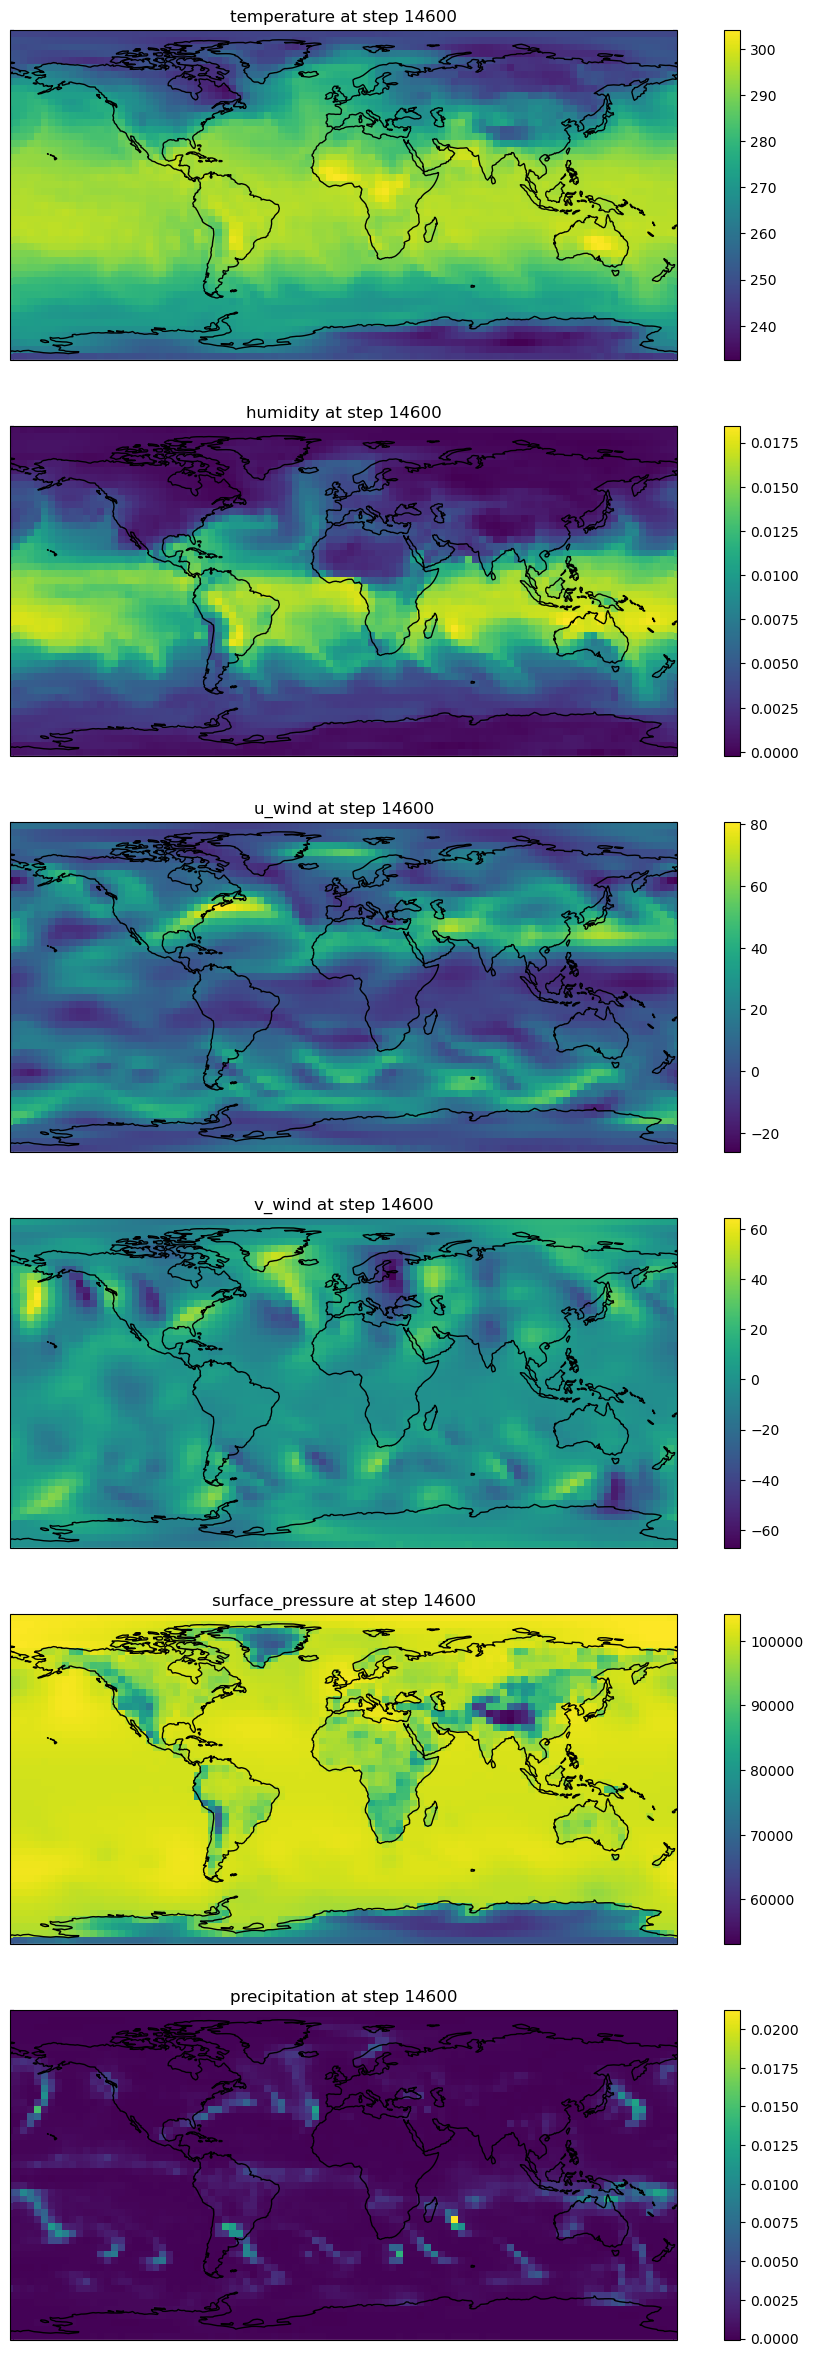

In [8]:
#results from Yue's checkpoint
# path = torch.load(f'{wdir}/checkpoints/136618981.gadi-pbs/regular_training_checkpoint.pth')
# model.load_state_dict(path)

# better checkpoint
#path = torch.load(f'{wdir}/checkpoints/137286020.gadi-pbs/lucie_205.pt')
#path = torch.load(f'{wdir}/checkpoints/137478626.gadi-pbs/lucie_158.pt')
#path = torch.load(f'{wdir}/checkpoints/138987659.gadi-pbs/lucie_340.pt')

#model.load_state_dict(path["model_state_dict"])

#rollout = inference(model, rollout_step, data_inp[initial_frame_idx].unsqueeze(0).to(device), forcing.to(device), forcing_initial_idx, prog_means, prog_stds, diag_means, diag_stds, diff_stds)


# visualize the final timestep of each ouptut var
w,h = 12,5
fig,axs = plt.subplots(nvars,1, figsize=(w,h*nvars),subplot_kw={'projection': ccrs.PlateCarree()},squeeze=False)
Lon, Lat = np.meshgrid(lon, lat)
for ii in range(nvars):
    pcm = axs[ii,0].pcolormesh(Lon,Lat,rollout[-1,ii,:,:])
    axs[ii,0].coastlines()
    axs[ii,0].set_title(f"{vars[ii]} at step {rollout.shape[0]}")
    fig.colorbar(pcm, ax=axs[ii])

# Check Climate Bias 

In [9]:
# mean clim_bias between year 1 and 10, it is expected to be different from what reported in the training 
rollout_clim = torch.mean(torch.tensor(rollout[1460:]).to(device),dim=0)
clim_bias = torch.mean(torch.abs(rollout_clim - true_clim))
clim_bias

tensor(14.0386, device='cuda:0')

In [10]:
# relative clim_bias by vars
rel_clim_bias = torch.mean(torch.abs((rollout_clim - true_clim)/true_clim),dim=(-2,-1))
list(zip(vars,rel_clim_bias.tolist()))

[('temperature', 0.0010665329173207283),
 ('humidity', 0.0559498555958271),
 ('u_wind', 0.8483986258506775),
 ('v_wind', 2.5114195346832275),
 ('surface_pressure', 0.0008711149566806853),
 ('precipitation', 0.1511058658361435)]

# Compare Global Mean over Time

In [11]:
# Compare global mean over time [year 1, year 10]
data = load_data(f"{wdir}/LUCIE_fix/era5_T30_regridded.npz")[...,:6]
true_clim_t = np.mean(data[1460:14600], axis=(1,2))
pred = torch.tensor(rollout[1460:]).detach()
pred_clim_t = torch.mean(pred,dim=(-1,-2))

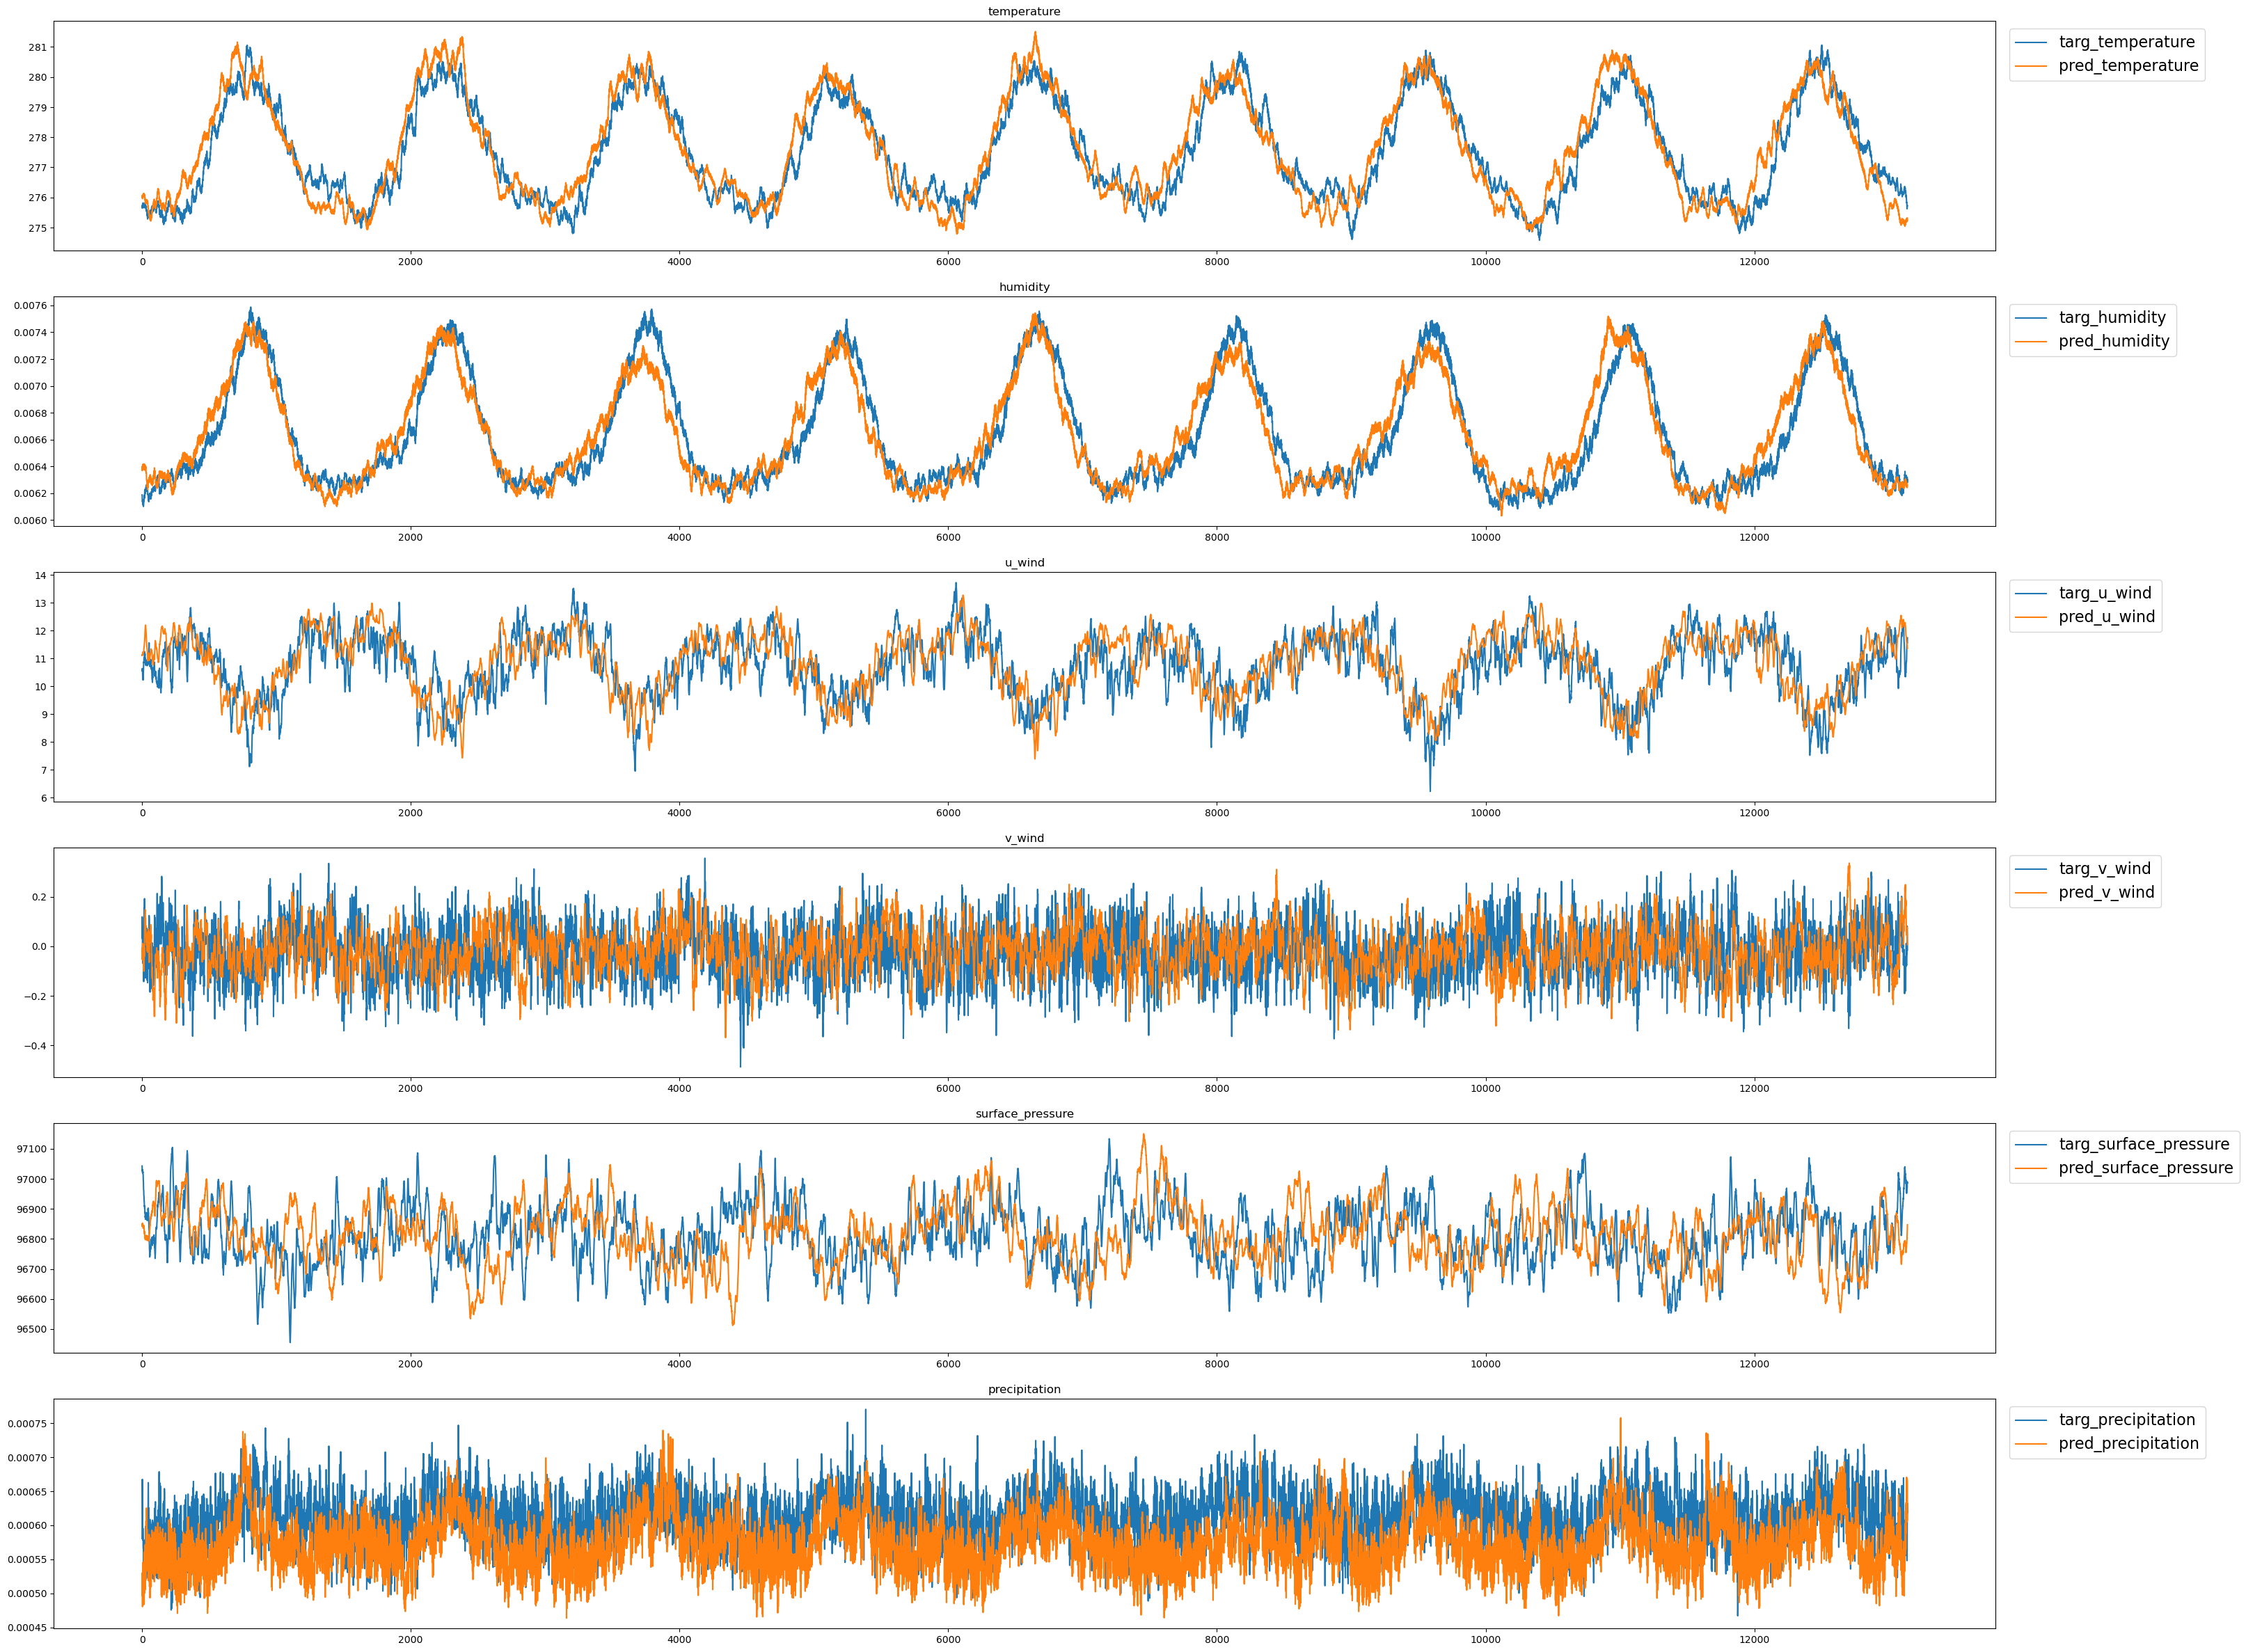

In [12]:
fig,axs = plt.subplots(nvars,1, figsize=(w*3,h*nvars))
for ii in range(nvars):
    pcm1 = axs[ii].plot(true_clim_t[:,ii],label=f"targ_{vars[ii]}")
    pcm2 = axs[ii].plot(pred_clim_t[:,ii],label=f"pred_{vars[ii]}")
    axs[ii].set_title(f"{vars[ii]}")
    axs[ii].legend(loc='upper left', bbox_to_anchor=(1.003, 1),fontsize=16)

# The END